In [1]:
import pandas as pd
pd.set_option("display.max_columns", 100)
import numpy as np
np.set_printoptions(suppress=True)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Any, Union

In [2]:
IN_CSV_DATA = Path().cwd().parent.parent / "data/4_data_split"
OUT_MODEL_DATA = Path().cwd().parent.parent / "data/5_models"

# 1. Load in Training and Test Datasets

In [3]:
df_train = pd.read_csv(IN_CSV_DATA/'prepared_train.csv')
df_test = pd.read_csv(IN_CSV_DATA/'prepared_test.csv')

In [4]:
numerical_feature_cols = ['total_distance_mi','total_weight_lbs','avg_cruising_speed', 'log_hours_since_last_ride',
                            'active_time_ratio', 'avg_climb_rate', 'distance_training_intensity','prior_training_load']
categorical_feature_cols = ['year']
feature_cols = numerical_feature_cols + categorical_feature_cols

target_cols = ['best_power_4s', 'best_power_5s',
                'best_power_10s', 'best_power_20s', 'best_power_30s', 'best_power_1m',
                'best_power_2m', 'best_power_3m', 'best_power_4m', 'best_power_5m',
                'best_power_6m', 'best_power_10m', 'best_power_20m', 'best_power_30m',
                'best_power_40m', 'best_power_1h', 'best_power_2h']

In [5]:
X_train, y_train = df_train[feature_cols].values, df_train[target_cols].values
X_test, y_test = df_test[feature_cols].values, df_test[target_cols].values

In [6]:
from sklearn.model_selection import cross_val_score, cross_val_predict, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, root_mean_squared_log_error
from sklearn.linear_model import LinearRegression

In [7]:
def timeseries_cross_validated_regression(X, y, regressor, k_folds=5):
    tss = TimeSeriesSplit(n_splits=k_folds)
    
    r2_scores = []
    rmsle_scores = []
    predictions = []
    actuals = []
    for train_index, val_index in tss.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        regressor.fit(X_train, y_train)
        
        y_pred = regressor.predict(X_val)
        # Ensure all predicted powers are non-negative
        y_pred[y_pred<0] = 0.0
        r2 = r2_score(y_val, y_pred, multioutput='uniform_average')
        # NOTE: RMSLE is chosen because it represents the average ratio error between the predicted and the true values.
        #       |--> This is useful because the RMSE error in the 5second effort duration is at a different power scale (kW) than a 20minute effort (Watts)
        # ref: https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a 
        # NOTE: RMSLE is biased in how it penalizes errors. It penalizes UNDERestimation more than OVERestimation
        # This means if we use y_true=y_val as it truly should match, we're okay with overestimating our power curves...
        # So we swap the ordering of these so that we're okay underestimating our power curves. We'd rather be conservative on our estimates of fitness
        rmsle = root_mean_squared_log_error(y_true=y_pred, y_pred=y_val, multioutput='uniform_average')
        r2_scores.append(r2)
        rmsle_scores.append(rmsle)

        predictions.append(y_pred)
        actuals.append(y_val)
    
    print(f'For metric "R^2", the mean = {np.mean(r2_scores)}, std.dev. = {np.std(r2_scores)}')
    print(f'For metric "RMSLE", the mean = {np.mean(rmsle_scores)}, std.dev. = {np.std(rmsle_scores)}')

    return {'actuals':actuals, 'predictions':predictions}

# 1. Baseline Models: Y=BX+eps, predicting the output matrix.

For each sample $x$, the regressor will predict a vector output of size 17x1

In [8]:
linreg = LinearRegression()

In [9]:
outputs = timeseries_cross_validated_regression(X_train, y_train, linreg, k_folds=5)

For metric "R^2", the mean = 0.17822019505868997, std.dev. = 0.24877182753801771
For metric "RMSLE", the mean = 0.7625795187147937, std.dev. = 0.1096291409855231


In [10]:
y_pred = outputs['predictions'][-1]
y_val = outputs['actuals'][-1]

In [11]:
r2 = r2_score(y_val, y_pred, multioutput='raw_values')

In [12]:
r2

array([-0.66844641, -0.68637483, -0.79131356, -0.95459559, -0.86479414,
       -0.05252147,  0.22559292,  0.02291145,  0.09089611,  0.17562415,
        0.19065364,  0.34313599,  0.14037088,  0.34335048,  0.45768167,
        0.298667  ,  0.63038437])

In [13]:
def plot_residuals(y_pred, y_true, column_names:list[str]):
    residual_error = y_true - y_pred
    fig, axes = plt.subplots(3,6, figsize=(16,6), sharex=True, sharey=True)
    columns = np.array(column_names+['none']).reshape(axes.shape)

    for row_i in range(axes.shape[0]):
        for col_j in range(axes.shape[1]):
            ax = axes[row_i, col_j]
            effort_index = (col_j) + (row_i)*(axes.shape[1])
            if effort_index+1 > len(column_names): continue # skip the last, 18ths box
            data = residual_error[:, effort_index]
            _ = ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
            _ = sns.scatterplot(data, ax=ax, alpha=0.75)
            _ = ax.set_title(columns[row_i, col_j])
            _ = ax.grid()
            _ = ax.set_axisbelow(True)

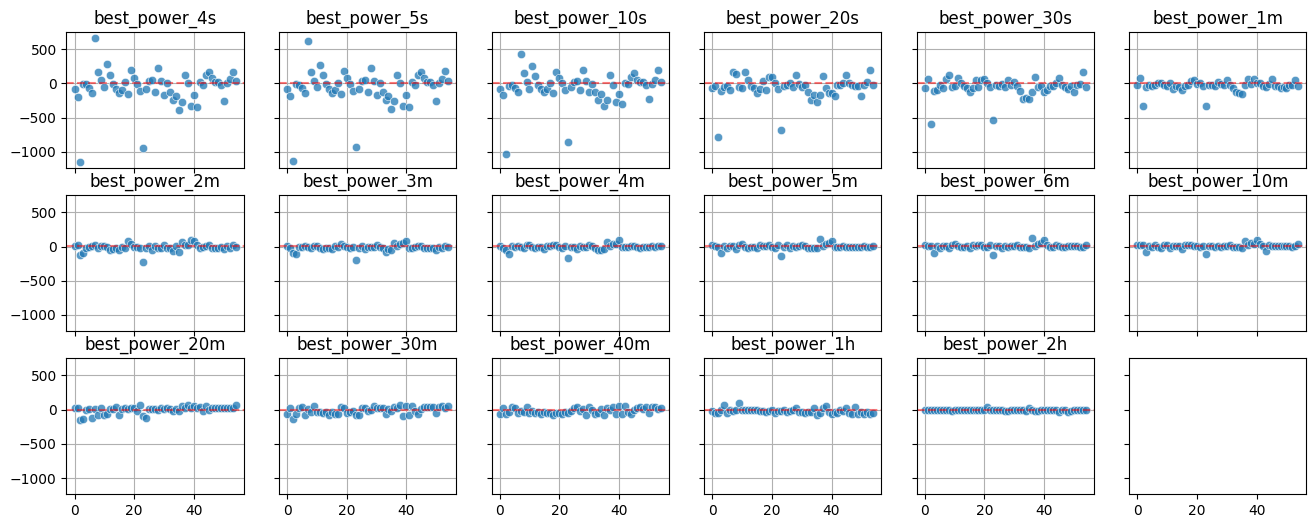

In [14]:
plot_residuals(y_pred, y_val, target_cols)

# 1. Baseline Models: $y_k = B_kx$ MultiOutput Regression

For each output target variable (17 of them), an independent model is created using the `MultiOutputRegressor` meta-estimator

ref: https://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_regression_multioutput.html

In [15]:
from sklearn.multioutput import MultiOutputRegressor

In [16]:
mo_linreg = MultiOutputRegressor(LinearRegression())

In [17]:
outputs = timeseries_cross_validated_regression(X_train, y_train, mo_linreg, k_folds=5)

For metric "R^2", the mean = 0.1782201950586901, std.dev. = 0.24877182753801758
For metric "RMSLE", the mean = 0.7625795187147937, std.dev. = 0.10962914098552311


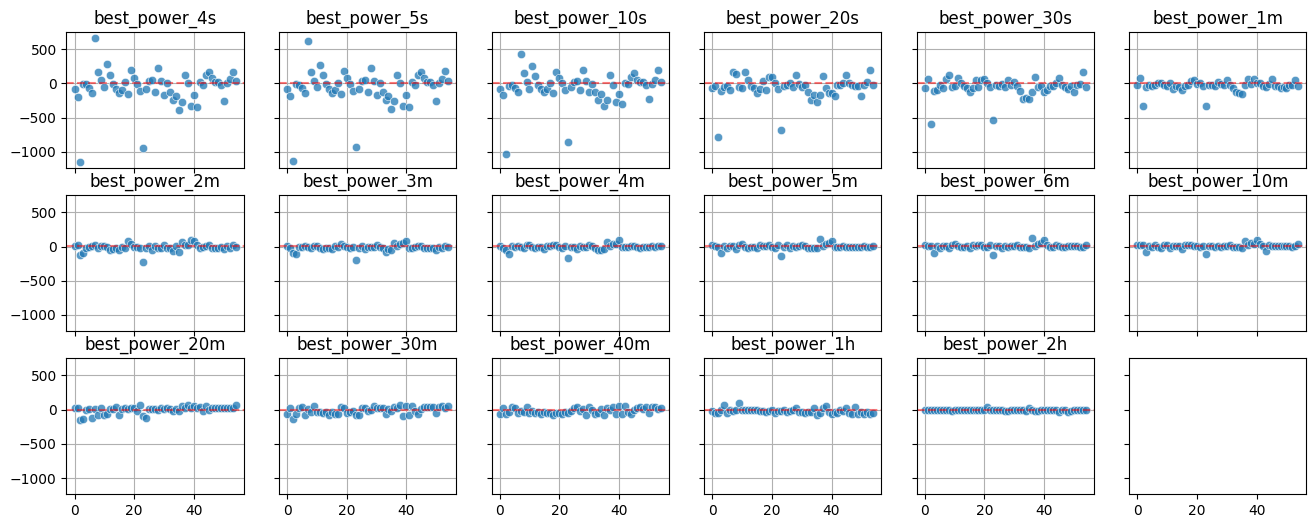

In [19]:
plot_residuals(outputs['predictions'][-1], outputs['actuals'][-1], target_cols)